In [2]:
from typing import Optional, Union, Tuple, List, Callable, Dict
import torch
from diffusers import StableDiffusionPipeline
import torch.nn.functional as nnf
import numpy as np
import abc
import ptp_utils
import seq_aligner

In [3]:
LOW_RESOURCE = False 
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
ldm_stable = StableDiffusionPipeline.from_pretrained("/root/autodl-tmp/ReVersion/stable-diffusion-2-1").to(device)
tokenizer = ldm_stable.tokenizer

In [4]:
class AttentionControl(abc.ABC):
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0
    
    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class EmptyControl(AttentionControl):
    
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        return attn
    
    
class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention


    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

In [5]:
from PIL import Image

def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def show_cross_attention(attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompts[select])
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = ptp_utils.text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    ptp_utils.view_images(np.stack(images, axis=0))
    

def show_self_attention_comp(attention_store: AttentionStore, res: int, from_where: List[str],
                        max_com=10, select: int = 0):
    attention_maps = aggregate_attention(attention_store, res, from_where, False, select).numpy().reshape((res ** 2, res ** 2))
    u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    ptp_utils.view_images(np.concatenate(images, axis=1))

def run_and_display(prompts, controller, latent=None, run_baseline=False, generator=None):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = ptp_utils.text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, low_resource=LOW_RESOURCE)
    ptp_utils.view_images(images)
    return images, x_t

  0%|          | 0/50 [00:00<?, ?it/s]

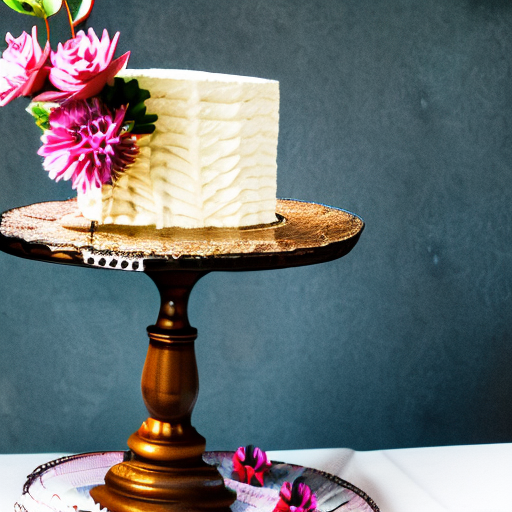

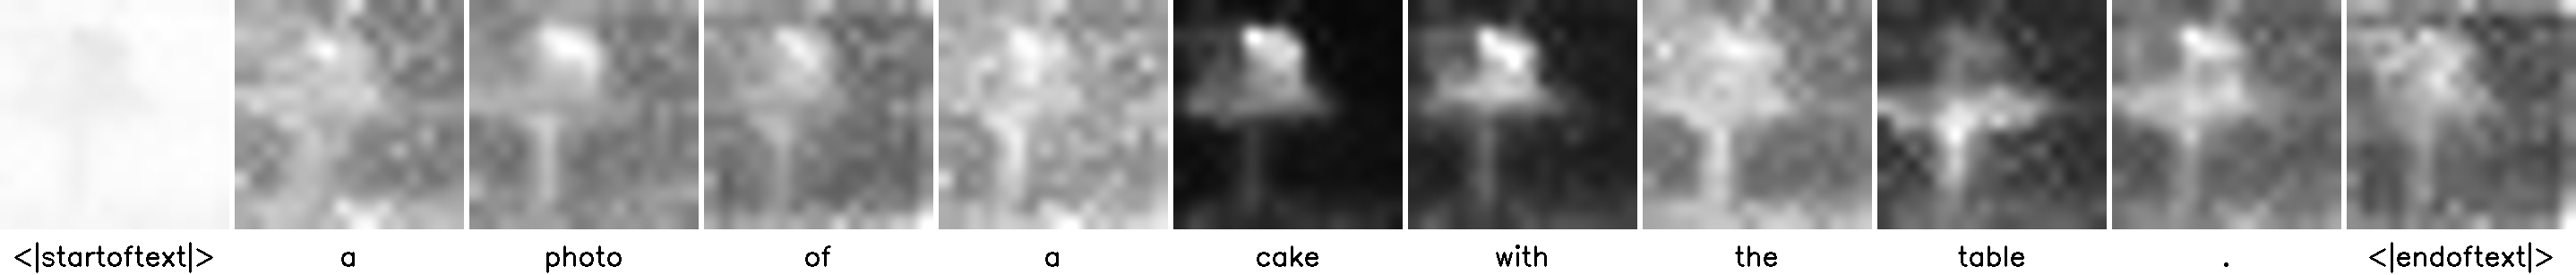

In [10]:
g_cpu = torch.Generator().manual_seed(8888)
prompts = ["a photo of a cake with the table."]
controller = AttentionStore()
image, x_t = run_and_display(prompts, controller, latent=None, run_baseline=False, generator=g_cpu)
show_cross_attention(controller, res=16, from_where=("up", "down"))